# PyTorch ile Görüntü Sınıflandırma  
<img src="https://upload.wikimedia.org/wikipedia/commons/9/96/Pytorch_logo.png" width=30% /> 

Geçtiğimiz hafta içinde [People In Data](https://www.facebook.com/peopleindata/) ve [Facebook DevC Stockholm](https://www.facebook.com/groups/devCstockholm/) ortaklığıyla düzenlenen etkinlikte **Udacity AI** mentorlerinden Pranjal ile tanışmış oldum ve harika bir webinar gerçekleştirdi. Tabi hem Pytorch'a ısınmam için hem de bu sırada meraklılarına faydalı olması adına bu notebook'u hazırlamaya karar verdim. Destek veren [Pranjal](https://www.linkedin.com/in/pranjall/?originalSubdomain=in)'a ve bu etkinlik hakkında beni haberdar ettiği için [Zümrüt](https://www.linkedin.com/in/zumrut-muftuoglu-98704537/)e teşekkürler.


Bu Colab Notebookda, Evrişimli Sinir Ağları temellerini kullanarak basit bir görüntü sınıflandırma çalışması uygularken [PyTorch Ekosistemindeki](https://pytorch.org/ecosystem/ "Click to visit the PyTorch Ecosystem homepage") yeniliklerden de faydalanacağız.




<br/>Not:
https://github.com/pranjalchaubey/Deep-Learning-Notes
 

### 1. Colab Üzerinde Veri Setini Veri Setlerini Kullanma 

Herhangi bir Makine Öğrenmesi / Veri Bilimi probleminde, ilk adım daima veri setini elde etmektir.

Bizim durumumuzda, başlangıçta basit [MNIST Veri Kümesini]((https://en.wikipedia.org/wiki/MNIST_database "Wikipedia to the rescue!") kullanacağız. MNIST yapay zekâ ve makine öğrenmesi çalışacak kişiler için 'Merhaba Dünya!' gibi bir başlangıçtır. [Bu veri kümesi size 90'ların sonlarından sesleniyor!]((http://yann.lecun.com/exdb/mnist/) 

![90s](https://media.giphy.com/media/ggKMDmjkGZ5ZK/giphy.gif)

_"MNIST'in resmi web sitesinden 60.000 örneklik bir eğitim seti ve 10.000 örneklik bir test seti şeklinde erişebiliyorsunuz. NIST tarafından sağlanan daha büyük bir kümenin bir alt kümesidir. Normalize edilmiş, ortalanmış ve aynı boyuta sahip el yazısı rakam görüntülerini barındırmaktadır. Ön işleme ve biçimlendirme için minimum çaba harcayarak, gerçek dünya verileri üzerinde öğrenme teknikleri ve örüntü tanıma yöntemleri denemek isteyen insanlar için iyi bir veri kümesidir."_


Merak ediyor olabilirsiniz, bu veri kümesini Colab Çalışma Alanımızda nasıl edinebilirsiniz? Önce bilgisayarınıza ya da Drive klasörünüze mi indirmeniz gerekir? Verilere nasıl erişebilirsiniz?

PyTorch, [Torchvision.Datasets]((https://pytorch.org/docs/stable/torchvision/datasets.html "Official Documentation") adlı bir veri kümesi modülü ile birlikte gelir. Torchvision.Datasets modülü, aradığımız MNIST dahil olmak üzere bir dizi halka açık veri kümesi içerir. Böylece kolayca verileri kullanabilirsiniz.


In [0]:
# Bazı gerekli kütüphanelerin import edilmesi (her zaman yaptığımız gibi)
import torch # PyTorch (TensorFlowcular için ilk farklı adım :) )
from torchvision import datasets # Datasetlere erişme modülü 
import torchvision.transforms as transforms # Görüntü transform etme için gerekli importlar 
from torch.utils.data.sampler import SubsetRandomSampler # Sampler 

In [0]:
# Veri Biliminin VAzgeçilmezleri Kütüphanler
import numpy as np 
import pandas as pd

**torchvision.datasets** modül dokümanına bir göz atalım! Böylece kullanım şekillerini ve hangi parametrelerle kullanabileceğinizi görebilirsiniz. 

<img src="https://drive.google.com/uc?id=1Zsgc5_PnO9BQQ5wqssf67A5Ge-qIXtLh" width=70% />


In [0]:
# Datayı torch.FloatTensor a dönüştürüyoruz
transform = transforms.ToTensor()

# Eğitim ve Test verilerini seçiyoruz.
train_data = datasets.MNIST(root='data', train=True,    # train=true => Eğitim seti 
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,    # train=false => Test seti 
                                  download=True, transform=transform)

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


### 2. Eğitim, Doğrulama/Geçerleme ve Test Kümelerinin Oluşturulması

İndirme işlemi tamamlandıktan sonra 'veri' klasörünüzde indirilen MNIST veri kümesini görebilirsiniz. 
Temel olarak eğitim ve test kümelerine ihtiyacımız var ancak bir de doğrulama kümesi ayırmalıyız eğitim kümesi içinden.

*   Eğitim Kümesi (%80 görüntü)
*   Doğrulama/Geçerleme Kümesi (%20 görüntü)

Bunu yapmak için kullandığımız algoritma oldukça basit;

1. Eğitim verilerinin endekslerinin bir listesini oluşturun.
2. Bu indeksleri rastgele karıştırın.
3. Endeksleri 80-20 bölünmüş olarak ayırın.

[Doğrulama/Geçerleme kümesine neden ihtiyaç var? Regularization yolları nelerdir?](https://www.youtube.com/watch?v=gbzwtZGrkrQ&t=4s) 

![Doğrulama Kümesi](https://i.hizliresim.com/bcHNzo.png)


In [0]:
# Doğrulama/Geçerleme için kullanılacak eğitim endeksleri elde etmek

# 1. Eğitim verilerinin endekslerinin bir listesini oluşturun 
num_train = len(train_data)
print('num_train = len(train_data) ==> ', num_train)
indices = list(range(num_train))
print('len(indices) ==>', len(indices))

num_train = len(train_data) ==>  60000
len(indices) ==> 60000


In [0]:
# 2. Bu indeksleri rastgele karıştırın
np.random.shuffle(indices)

In [0]:
# 3. Endeksleri %80 eğitim için %20 doğrulama/geçerleme olarak bölün.
valid_size = 0.2 # Eğitim kümesi iki parçaya ayrılmaya çalışılıyor
                 # 80% eğitim 20% doğrulama/geçerleme 
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

print('len(train_idx) ==> ', len(train_idx))
print('len(valid_idx) ==> ', len(valid_idx))

len(train_idx) ==>  48000
len(valid_idx) ==>  12000


Şimdiye kadar sadece **'endekslerle'**  \``(indices)`\` uğraşıyoruz, gerçek görüntülerle değil! Ama neden?

O zaman cevapla devam edelim...

### 3. Dataloaderların Hazırlanması 

Veri kümesini indirdik ve bir tren / geçerli / test bölümü oluşturduk.
Soru: Bu verileri bir PyTorch modeline nasıl (_'push'_) ekleyeceğiz?
Cevap: PyTorch, bir veri kümesindeki verileri bir modül aracılığıyla (_'ingest'_) alma mekanizmasına sahiptir ve bu 
`DataLoader` olarak bilinir.

Harika bir benzetme ile  

![DataLoader](https://drive.google.com/uc?id=1U4IG-5lbFGQQS4xwQPU2QiYdR1hFGBZ5 "Always remember, Deep Learning Model is Your Baby and you got to feed it well!")

[Kullanışlı bir DataLoaders Anlatımı](https://www.journaldev.com/36576/pytorch-dataloader "PyTorch DataLoader")  
[Stanford Üniversitesi DataLoaders Notları](https://stanford.edu/~shervine/blog/pytorch-how-to-generate-data-parallel "A detailed example of how to generate your data in parallel with PyTorch") 

Şimdi _DataLoaders_ hazırlama zamanı!

<img src="https://drive.google.com/uc?id=1YFbWIGwNlL5Kp4Zvt52Ck0_Wk4MNfxS9" width=70% />


In [0]:
# eğitim ve doğrulama gruplarını elde etmek için samplers tanımlamamız gerekecek
# unutmayın yukarıda train_idx ve valid_idx indekslerin kullanmıştık

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# dataloaderların hazırlanması
# veri yükleme için kullanılacak alt işlemlerin sayısı
num_workers = 0 # burayı değiştirmeyin
# her bir batch için yüklenecek örnek sayısı
batch_size = 20 # örneğin 20 seçebilirsiniz

# EĞİTİM KÜMESİ
train_loader = torch.utils.data.DataLoader(dataset=train_data, \
                                           batch_size=batch_size, \
                                           sampler=train_sampler, \
                                           num_workers=num_workers)
# DOĞRULAMA/GEÇERLEME KÜMESİ 
valid_loader = torch.utils.data.DataLoader(dataset=train_data, \
                                           batch_size=batch_size, \
                                           sampler=valid_sampler, \
                                           num_workers=num_workers)
# TEST KÜMESİ
# Gerekli olmadığı için burada bir 'sample' kullanmadığına dikkat edelim
test_loader = torch.utils.data.DataLoader(dataset=test_data, \
                                          batch_size=batch_size, \
                                          num_workers=num_workers)

Veri yüklekmek için dataloaderları çalıştırdık, ama gerçekten çalıştıklarını nasıl biliyoruz?
Dataloaderlar verilerinin görselleştirelim ve kontrol edelim! 

In [0]:
# Verileri toplu olarak görselleştirelim 

dataiter = iter(train_loader) # tüm batch i alalım  
images, labels = dataiter.next() # Görüntüleri ve onların etiketlerini elde edelim 
print(len(images), len(labels)) # Bu kısım batch sayısına yani 20'ye eşit olmalıdır.
print('Correct Labels: ', labels)
images = images.numpy() # Matplotlib için görüntüleri numpy dizisine dönüştürme
print('Shape of our images tensor =', images.shape)
print('Batch Size =', images.shape[0], 'Image Height/Width =', \
                                                        images.shape[2])

print()
print('Squeezing the images tensor =', np.squeeze(images).shape)
print('Un-squeezing the images tensor (axis=3) =', \
                                        np.expand_dims(images, axis=3).shape)

20 20
Correct Labels:  tensor([0, 8, 9, 2, 4, 2, 6, 4, 4, 6, 9, 2, 9, 2, 5, 9, 9, 5, 9, 2])
Shape of our images tensor = (20, 1, 28, 28)
Batch Size = 20 Image Height/Width = 28

Squeezing the images tensor = (20, 28, 28)
Un-squeezing the images tensor (axis=3) = (20, 1, 28, 1, 28)


In [0]:
import matplotlib.pyplot as plt 
# Grafikler 'inline' ile notebook üzerinde çizilir
%matplotlib inline 


[Matplotlib kullanımı için kaynak](https://realpython.com/python-matplotlib-guide/ "Real Python has some of the best Python Tutorials on the Internet...no kidding!")

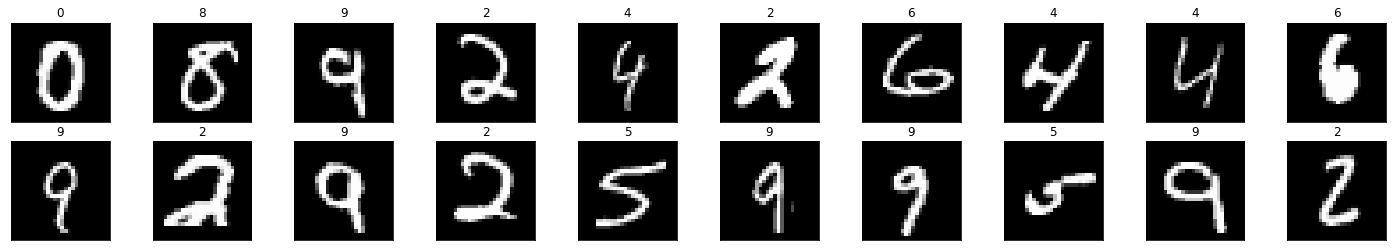

In [0]:
# Tüm batch i çizdirelim
fig = plt.figure(figsize=(25, 4))
# Batch sayısı kadar bir for döngüsü ile her bir batch i çizdirmiş olalım 
for idx in np.arange(20):
    # Tüm eksene bir görüntüyü daha ekleme
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    # Tüm subplot u görsellerle işleriz bu adımda
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # Her görüntünün Label ı başlık olarak eklenir
    # .item() bir tensörde bulunan değeri alır
    ax.set_title(str(labels[idx].item()))

In [0]:
# Peki o halde spor olsun diye küçük bir numara deniyelim!

dataiter = iter(train_loader)  
images, labels = dataiter.next() 
images = images.numpy() 
np.set_printoptions(precision=2, threshold=None, edgeitems=None, \
                    linewidth=180, suppress=None)
print('Label', labels[0])
print(images[0])

Label tensor(9)
[[[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
  [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
  [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
  [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
  [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
  [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.08 0.82 1.   1.   1.   1.   0.3  0.   0.   0.   0.   0.   0.   0.  ]
  [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.02 0.6  0.95 0.99 0.99 0.99 0.91 0.92 0.3  0.   0.   0.

Verierimiz gayet güzel görünüyor!
<br/> 
Artık CNN tabanlı görüntü sınıflandırma modelimizi PyTorch'ta üretme zamanı ... 2020'de!

### 4. PyTorch Kullanarak CNN Modeli Oluşturma
Ancak önce CNN'lerin nasıl çalıştığını ve tipik bir CNN tabanlı görüntü sınıflandırma mimarisinin bileşenlerini bilmemiz gerekir.

Gelsin pikseller, başlıyoruz :)

<img src="https://media.giphy.com/media/26ufc8n6KYsFpuzoA/giphy.gif" width=20% /> 



####4.1.1 Evrişimli Sinir Ağı (CNN) Mimarisi  
Bilinen temel bir evrişimli sinir ağı mimarisi aşağıdakine benzerdir;  

<img src="https://drive.google.com/uc?id=1RYYh27hsyY5Mx4L_lwGUVGQ3OYkSCqB-" width=60% />

<br/> Bu notebookda çalışacağımız modele yakın bir model de bu,  
<img src="https://drive.google.com/uc?id=1cnDzorKeRmNUAUJYw2yvQiY2D4f-sDNL" width=60% />

Tüm bu mimarileri daha detaylı öğrenmek isterseniz

[DERİNE DAHA DERİNE: Evrişimli Sinir Ağları](https://medium.com/@ayyucekizrak/deri%CC%87ne-daha-deri%CC%87ne-evri%C5%9Fimli-sinir-a%C4%9Flar%C4%B1-2813a2c8b2a9)


<img src="https://media.giphy.com/media/l2uBoH5AT2lOTH9ayR/giphy.gif" width=30% /> 

####4.1.2 Temel bir CNN Katmanı 
Peki, CNN katmanı aslında nasıl iş yapıyor? 

![Evrişim İşlemi](https://drive.google.com/uc?id=1JictobCPmaIX_9pm2mQewc4QiAzl0pzO "Remember Billie Eilish above?")  

<br/>Renkli bir görüntü 3 kanaldan meydana gelir (RGB),  
![RGB Görüntü Temsili](https://drive.google.com/uc?id=1QlU04TZ6IN2IRqQJFB8m6GFJ2MmqYGhz "https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53")  

<br/>3 Kanallı evrişim işlemi,  
![RGB Evrişim](https://drive.google.com/uc?id=1CGIqxGHjJGXr8aduPtwGd1-ikgA3WqJ5 "https://towardsdatascience.com/a-comprehensive-introduction-to-different-types-of-convolutions-in-deep-learning-669281e58215")  

![RGB Evrişim Toplamı](https://drive.google.com/uc?id=1fpM3NLvyjeiKF6_at0Nv4XhYPRkwH1IY "https://towardsdatascience.com/a-comprehensive-introduction-to-different-types-of-convolutions-in-deep-learning-669281e58215")


####4.1.3 Adım kaydırma (Stride)  
_'Stride'_ görüntü üzerindeki işlemi kaç adım kaydırarak devam edeceğimizi belirleriz.  

Hemen bir örnekle başlayalım:  _stride=1_,  - Durumu değiştirisek nasıl olur peki:  _stride=2_,

<img src="https://drive.google.com/uc?id=1wJd7VCYfiMDes0Ex0SlBL97yBP6P7ajt " width=30% />


<img src="https://drive.google.com/uc?id=1dG2i4WtxUzu9Wlsl3jyH4ZXxUSYVdKfk " width=35% />


####4.1.4 Piksel Ekleme (Padding) 
İşlemi uygulayacağımız görüntünün çevresine ekleyeceğimiz pikseller ya da doldurma işlemi de diyebiliriz bize çıkış boyutunun azalmamasını sağlar ve daha az bilgi kaybetmemize yarar. Bu pikselleri tamamen 0, tamamen 255 ya da çevresindeki piksel değerlerini kopyalayarak da yapabiliriz. 

<img src="https://drive.google.com/uc?id=1xIQSJVRtAS7em_E387ZBd6sErjwA7RD6" width=30% />

####4.1.5 Maksimum Ortaklama (Max-Pooling) 

Ortaklama işlemi ile yapmak istediğimiz boyut azaltma ve işlem yükünü hafifletmektir. Sıklıkla maksimum ortaklama kullanılabileceği gibi ortlama (average) ya da medyan (medium) ortaklama da tercih edilebilir.

<img src="https://drive.google.com/uc?id=11_1ThNaU4e4DAEFs7I9GsNoD7oFmtVES " width=40% />

<img src="https://drive.google.com/uc?id=1ECZrE8vAhTE1gEsp_3vPy03oLuSj0aOW" width=30% />


[Ortaklama türlerini anlatan güzel bir kaynak!](https://machinelearningmastery.com/pooling-layers-for-convolutional-neural-networks/ "Jason Brownlee is an absolute genius. His blog is a damn goldmine!") 

####4.1.6 Aktivasyon Fonksiyonu: ReLU (Rectified Linear Units)

Aktivasyon fonksiyonları sinir ağlarında kilit bir rol oynar, bu nedenle daha iyi performans elde etmek için avantajlarını ve dezavantajlarını anlamak esastır.

Çoğunlukla CNN modellerde ReLU kullanılır, bu çalışmada da öyle yapacağız.
![ReLU Activation](https://miro.medium.com/max/487/1*UN79Z_9jSAEqvd5jiov32Q.png "https://medium.com/@ayyucekizrak/derin-%C3%B6%C4%9Frenme-i%C3%A7in-aktivasyon-fonksiyonlar%C4%B1n%C4%B1n-kar%C5%9F%C4%B1la%C5%9Ft%C4%B1r%C4%B1lmas%C4%B1-cee17fd1d9cd")

Ama siz bu avantaj ve dezavantajları merak ederseniz hem video içeriği olan hem blog yazısı olan bir diğer çalışmamı ekliyorum:

Blog: [Derin Öğrenme İçin Aktivasyon Fonksiyonlarının Karşılaştırılması](https://medium.com/@ayyucekizrak/derin-%C3%B6%C4%9Frenme-i%C3%A7in-aktivasyon-fonksiyonlar%C4%B1n%C4%B1n-kar%C5%9F%C4%B1la%C5%9Ft%C4%B1r%C4%B1lmas%C4%B1-cee17fd1d9cd)

Video: [Derin Öğrenme İçin Aktivasyon Fonksiyonlarının Karşılaştırılması](https://www.youtube.com/watch?v=ZMkLC-ebIqE)

####4.1.7 Tam Bağlantılı, Lineer Bağlantılı Katmanlar (_Fully Connected_ or _Linear Layers_)  
Sınıflandırma veya regresyon görevleri için nihai boyutsal azalmayı yaptığımız katmanlardır. 

<img src="https://i.hizliresim.com/cJgfL8.png" width=60% />

**İlerlemeden önce, herkes için birkaç soru:**

1. İlk birkaç CNN katmanı ne tür öznitelikleri yakalar?
2. Son birkaç CNN katmanı ne tür öznitelikleri yakalar?
3. Maksimum ortaklamanın rolü nedir?
4. Maksimum ortaklamaya benzer bir rol gerçekleştirmek için stride kullanabilir miyiz?

Bu soruları cevaplayabildğinize emin olun :) 

<img src="https://media.giphy.com/media/xULW8vi25RrpxQrmrm/giphy.gif" width=40% /> 







 

####4.2.1 PyTorch  (Gelelim Sadede)

PyTorch popüler Deep Learning kütüphanelerinin ön sıralarında yer alıyor. Popülerlik açısından, Tensorflow'u bile ele geçmiş olabilir. Emin değilim (: 

Tensorflow, _PyTorch_'tan önce kullanılmaya başladı ve Biliyoruz ki _Google_'ın mühendislik ve pazarlama gücü tarafından destekleniyor. Bu kötü bir şey değil bu arad öyle anlaşılmasın :)

_Peki, PyTorch neden/nasıl bu kadar ünlü oldu?_
Çünkü, PyTorch araştırmacı ve geliştiriciler için dinamik hesaplama grafikleri nedeniyle son derece esnek ve ideal olmasındandır.
  

####4.2.2 Hesaplamalı Grafikleri (Computational Graph) Anlama

Her Derin Sinir Ağı eğitiminin altında, sadece iki temel süreç işler: 

1.  İleri Yayılım (Yeşil oklar) - ağın başlangıcından itibaren görüntüleri / verileri giriş ve bir çıktı arasında (bir kayıp / hata) oluşturma.
2. Geri yayılım (Kırmızı oklar) - esas olarak, kayıpla ilgili kısmi türevler kullanarak gradyanları hesapladığımız ve ağın ağırlıklarında değişiklikler yaptığımız bir işlemdir. Özetle, derin öğrenme ağları bu şekilde eğitilir.

<img src="https://i.hizliresim.com/Q59ANM.png" width=60% />

Yukarıdaki görüntü basit bir sinir ağıdır. Ama aynı zamanda bir hesaplama grafiğidir. _Kaynak: Udemy - Python ile Derin Öğrenme dersi._

Öncelikle ağımızdan ileriye doğru, daha sonra özellikle _** W1 **_ ağırlığından ne kadar hata olduğunu hesaplamak için geriye doğru bir yayılım yapıyoruz.

Tanımladığınız her sinir ağı, bunu gördüğümüze benzer bir hesaplama grafiği olarak PyTorch _sees_ yapar ve her düğüm tarafından gerçekleştirilen tüm işlemleri izler. Bu, geriye doğru yayılımı yaparken doğrusal gradyanların hesaplanmasını sağlar.

PyTorch ile ilgili en iyi şey, bu hesaplamalı grafikleri anında oluşturmasıdır! Ve bu özellik PyTorch'u ve son derece esnek **(pythonic)** derin öğrenme kütüphanesini yapar.

![Dynamic Computational Graphs](https://cdn.analyticsvidhya.com/wp-content/uploads/2019/09/dynamic_graph.gif "PyTorch building dynamic computational graphs on the fly")

####4.2.3 Tensörler
Tensörler de dahil olmak üzere her derin öğrenme kütüphanesinin yapı taşlarıdır.

Tensörler nedir?  
x,y,z boyutu olan veriler diyebiliriz.

<img src="https://drive.google.com/uc?id=1F5cLclu4RML7zj7axf8IGU7aUXJlI7N0 " width=40% />

PyTorch'ta tensörler oluşturmak kolaydır 
```
import torch 
x = torch.rand(3, 3)
print(x)

>>Prints out:
>>tensor([[0.5264, 0.1839, 0.9907],
>>        [0.0343, 0.9839, 0.9294],
>>        [0.6938, 0.6755, 0.2258]])
```
PyTorch'taki tensörler tam olarak numpy dizilerine benzer, ancak onları gerçekten çok hızlı yapan bir GPU'da da çalıştırabilir!  
```
torch.FloatTensor([[20, 30, 40], [90, 60, 70]]) # CPU üzerinde Tensor
torch.cuda.FloatTensor([[20, 30, 40], [90, 60, 70]]) # GPU üzerinde Tensor
```
Tensörleri (ve karmaşık derin öğrenme modellerini) bir GPU'ya (veya CPU'ya) taşımak PyTorch'ta oldukça basittir.
```
x = torch.FloatTensor([[20, 30, 40], [90, 60, 70]]) # CPU üzerinde Tensor
print('Is tensor x on GPU?', x.is_cuda) # False
x = x.to('cuda') # GPU'ya geçme
print('Is tensor x on GPU?', x.is_cuda) # True 
x = x.to('cpu') # Tekrar CPU'ya dönme
print('Is tensor x on GPU?', x.is_cuda) # False
```

####4.2.4 Autograd Modülü 

**Autograd**, PyTorch'taki gerçek rockstar modülüdür.

Autograd, bir tensör üzerinde yapılan tüm işlemleri takip eden ve **Otomatik Gradyan** - _(Automatic  
Differentiation)_ adı verilen bir teknikle hesaplayan modüldür.

Bir tensörde hesaplama geçmişini etkinleştirmek için, _**`.requires_grad`**_ değerini _**`True`**_ olarak ayarlamalısınız. Bir tensörü hesaplama geçmişinden ayırmak için _**`.detach()`** öğesini çağırmalısınız.

Autograd'ın hesaplamaların geçmişini derin bir öğrenme modelinde tutmasını durdurmak için, _**`torch.no_grad():`**_ kullanlamalısınız. Bu genellikle çıkarım sırasında yapılır.

```
with torch.no_grad():
``` 

####4.2.5 nn.Module  

PyTorch'taki **nn modülü**, sinir ağlarını 'oluşturmak' için kullanılır ve tüm derin öğrenme katmanlarını içerir. Gradyanları hesaplamak açıkça autograd modülüne bağlıdır.

Özel modellerimizi PyTorch'ta tanımlarken, nn.Module sınıfını alt sınıflara ayırırız ve `__init__()` ve f`forward()` fonksiyonlarnı geçersiz kılar.
1. `__init__()` - Bu, ağımızın katmanlarını tanımladığımız yerdir. 
2. `forward()` - Bu, katmanları gerçekten birbirine bağladığınız ve her şeyin çalışmasını sağlayan yerdir.

Bu biraz kafa karıştırıcı geliyorsa endişelenmeyin, `nn.Module`'u çok yakında göreceğiz!

####4.2.6 Optim Paketi 
The optim package in PyTorch contains the optimization algorithms that help   
to train your network.  

PyTorch'daki Optim paketi ağı eğitmek için yardımcı olan optimizasyon algoritmalarını içeriyor.

Basit bir örnek,

`optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)`  


Her zaman daha fazla kaynak isteriz (:
<br/>[Pranjal'ın favori kaynağı: 'Intro to PyTorch'](https://towardsdatascience.com/understanding-pytorch-with-an-example-a-step-by-step-tutorial-81fc5f8c4e8e "Understanding PyTorch with an example: a step-by-step tutorial")  
[- PyTorch Tutorial Part 1](https://blog.paperspace.com/pytorch-101-understanding-graphs-and-automatic-differentiation/ "PyTorch 101, Part 1: Understanding Graphs, Automatic Differentiation and Autograd")  
[- PyTorch Tutorial Part 2](https://blog.paperspace.com/pytorch-101-building-neural-networks/ "PyTorch 101, Part 2: Building Your First Neural Network")  
[- PyTorch Tutorial Part 3](https://blog.paperspace.com/pytorch-101-advanced/ "PyTorch 101, Part 3: Going Deep with PyTorch")  
[- PyTorch Tutorial Part 4](https://blog.paperspace.com/pytorch-memory-multi-gpu-debugging/ "PyTorch 101, Part 4: Memory Management and Using Multiple GPUs")  
[- PyTorch Tutorial Part 5](https://blog.paperspace.com/pytorch-hooks-gradient-clipping-debugging/ "PyTorch 101, Part 5: Understanding Hooks")  
[Stunning Insight into the Internals of PyTorch](http://blog.ezyang.com/2019/05/pytorch-internals/ "PyTorch Internals")

####4.3 Modelimizi tanımlama zamanı!
Ancak model tanımına başlamadan önce, PyTorch Dokümanlarının Evrişimli Sinir Ağları hakkında ne söylediğine bakalım.  

<img src="https://drive.google.com/uc?id=1odHZIXURYjogjUcyCQ56RYfQPqgzO7DX" width=70% />


<br/> Ayrıca MaxPool, Dropout ve Lineer Katmanları da kontrol etmeliyiz. 

<img src="https://drive.google.com/uc?id=1r1EeLHrV5oAG4OUyRSm0lw2OcZyJQ7ne" width=70% />

<img src="https://drive.google.com/uc?id=1kYgb4wDrGEBEF5WB169N7Q5hTrwDDO1d" width=70% />

<img src="https://drive.google.com/uc?id=1rrIEqPtun_8Td1js76B2hv22Xm5tjY6m" width=70% />

  

**Conv2d** ve **Linear** katmanlarda garip bir anormallik fark ettiniz mi?
```
torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')
```  
```
torch.nn.Linear(in_features, out_features, bias=True)
```

Conv2d katmanı `in_channels`, Linear katmanı `in_features` istiyor.

Sonuç olarak, PyTorch bir tensör boyutundan farklı şeyler beklemektedir.

Ne gibi derseniz;
 
```
"""Örnek tensör boyutu çıktıları, PyTorch'un bunları nasıl okuduğu ve vahşi doğada karşılaştığınız yer.
Not: Aşağıdaki değerler sadece örnektir. Tensörün rankına odaklan (kaç boyutu var)."""
>>> torch.Size([32])
    # 1d: [batch_size] 
    # hedef etiketleri ya da kestirimi kullan.
>>> torch.Size([12, 256])
    # 2d: [batch_size, num_features (aka: C * H * W)]
    # Giriş olarak nn.Linear() kullan.
>>> torch.Size([10, 1, 2048])
    # 3d: [batch_size, channels, num_features (aka: H * W)]
    # nn.Conv1d() giriş olarak kullandığında.
    # (fakat [seq_len, batch_size, num_features]
    # RNN'i besliyorsa).
>>> torch.Size([16, 3, 28, 28])
    # 4d: [batch_size, channels, height, width]
    # nn.Conv2d() giriş olarak kullan.
>>>  torch.Size([32, 1, 5, 15, 15])
    # 5d: [batch_size, channels, depth, height, width]
    # nn.Conv3d() giriş olarak kullan.
```    
Tensörlerinizi doğrusal katman için hazır hale getirmek için temiz bir yöntem,  
```
Tensörünüzün boyutlarını değiştirmek için view () öğesini kullanın.

image = image.view(batch_size, -1)

Batch_size'nizi ilk sayı olarak veriyorsunuz ve daha sonra “-1” temelde Pytorch'a “lütfen, benim için bu diğer sayıyı anlıyorsun… ” diyorsunuz.
Tensörünüz artık herhangi bir doğrusal katmana düzgün şekilde beslenecektir.
```

[PyTorch Katman Boyutlarını Anlatan Harika Bir Kaynak](https://towardsdatascience.com/pytorch-layer-dimensions-what-sizes-should-they-be-and-why-4265a41e01fd "Eye opener of an article, must read!")

Başlamadan önce yine kendimizi bir sorguya çekelim;

1. Görüntülerimizin şekli (boyutları) nedir? (shape / dimesions)
2. Bacth boyutumuz nedir?
3. Görüntülerimizde kaç _'kanal'_ vardır? (channels)
 
<img src="https://drive.google.com/uc?id=193KFtV2hr-7VkhQUJxd36oCF6Ms12xwD" width=40% />


In [0]:
import torch.nn as nn # nn modülü tüm katmanları içerir 
import torch.nn.functional as F # nn ile aynı, fakat küçük bir fark var 

In [0]:
# CNN Mimarisi
# Sadece Evrişi, Lİneer ve Dropout katmanları ile basit bir mimari oluşturalım
class MNISTModel1(nn.Module):
    # Burada sinir mimarisini tanımlıyoruz 
    def __init__(self):
        super(MNISTModel1, self).__init__() # nn module başlangıç
        
        # Evrişim Katmanları
        # İlk katmanın hangi şekli / boyutları (shape / dimension) göreceğini biliyor muyuz?
        # Bir kernel_size = 3 için biraz piksel eklemeye (padding) ihtiyacımız var mı?  
        # Giriş Öznitelikleri = 1 x 28 x 28
        # Çıkış Öznitelikleri = ???
        # Evrişim katmanının boyutları   = (W - K + 2P)
        #                                  ------------ + 1
        #                                       S
        # burada, 
        #       W = Önceki katmanın Yükseklik/Genişlik = 28
        #       K = Filtre Boyutu = 3
        #       P = Piksel ekleme (Padding) = 0
        #       S = Adım Aralığı (Stride) = 1(default)
        # Bu nedenler, 
        #           Eğer piksel ekleme = 0
        #           Çıkış şekli (shape) = ((28 - 3 + 2*0)/1)+1 = 26 
        # Evrişimi gerçekleştirirken hiçbir bilgi kaybının olmaması için boyutların aynı kalmasını istiyoruz. 
        # Bundan dolayı, 
        #       Eğer piksel ekleme = 1
        #       Çıkış şeli = ((28 - 3 + 2*1)/1)+1 = 28
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, \
                               stride=1, padding=1) # Çıkış Öznitelileri = 8 x 28 x 28  
        # Giriş Öznitelikleri = 8 x 28 x 28
        # Çıkış Öznitelikleri = 16 x 28 x 28 | ((28 - 3 + 2*1)/1)+1 = 28
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, \
                               stride=1, padding=1)

        # Lineer/Doğrusal Katmanlar 
        # İlk doğrusal katmanın şekli nasıl olacak?
        # Conv2 tarafından verilen toplam özellik sayısı nedir?
        # Öznitelikler = 16 x 28 x 28 = 12544
        # Bu sebeple           
        self.linear1 = nn.Linear(in_features=12544, out_features=256)
        self.linear2 = nn.Linear(in_features=256, out_features=64)
        # Son lineer/doğrual katman, görüntüleri 10 kategoride sınıflandırdığımız için 10 özellik çıkarmalıdır
        self.linear3 = nn.Linear(in_features=64, out_features=10)

        # Dropout 
        self.dropout = nn.Dropout(p=0.25)

    # Burada nöral mimarimizin 'ileri davranışını' tanımlıyoruz 
    def forward(self, image_batch):
        # Burası aynı zamanda AKTİVASYON fonksiyonlarını eklediğimiz yerdir
        image_batch = F.relu(input=self.conv1(image_batch))          
        image_batch = F.relu(input=self.conv2(image_batch))  
        

        # image_batch öğesini Lineer katmanlardan geçirirken PyTorch'un şunları beklediğini unutmayın:
        # >>> torch.Size([12, 256]) -> Örnek değerler
            # 2d: [batch_size, num_features (aka: C * H * W)]
            # nn.Linear() giriş olarak kullanılır.   
        # Bu nedenle, 'flatten' image_batch ihtiyaç duyarız.
        # image_batch = image_batch.view(batch_size, -1) --> batch boyutu ne olabilir ???
        flat_image_batch = image_batch.view(image_batch.shape[0], -1)
        flat_image_batch = F.relu(input=self.linear1(flat_image_batch))
        # Buraya da bir dropout ekleyelim!
        flat_image_batch = self.dropout(F.relu(input=self.linear2(flat_image_batch)))
        # Ağın son lineer kaymanları
        flat_image_batch = F.relu(input=self.linear3(flat_image_batch))
        # Son katmandan elde edilen çıktı 10 'logit' ile bir tensördür
        return flat_image_batch               

Şimdi modelimizi tanımladığımıza göre, neler olup bittiğini ve her şeyin yolunda olduğunu görmek için içeriyi kontrol edip, bakabilmemizin bir yolu var mı?
Tabi ki var! 

 _**[torchsummary](https://github.com/sksq96/pytorch-summary "Click to visit GitHub Page")**_'ye merhaba diyin!!!

In [0]:
# Torchsummary kuralım ve bazı harika şeyler yapalım
!pip install torchsummary # https://github.com/sksq96/pytorch-summary 

In [0]:
from torchsummary import summary 

In [0]:
# Burada yanlış bir şey yapıp yapmadığımızı anlamak için meşale kütüphanesini kullanabiliriz

# Ama önce PyTorch'a modeli nerede 'tutacağını' söylememiz gerekiyor
# GPU'da veya CPU'da
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
print('The model will run on', device)

# Modeli Başlatma
mnist1 = MNISTModel1().to(device)
summary(model=mnist1, input_size=(1, 28, 28), batch_size=20) # Özet (Summarize)

The model will run on cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [20, 8, 28, 28]              80
            Conv2d-2           [20, 16, 28, 28]           1,168
            Linear-3                  [20, 256]       3,211,520
            Linear-4                   [20, 64]          16,448
           Dropout-5                   [20, 64]               0
            Linear-6                   [20, 10]             650
Total params: 3,229,866
Trainable params: 3,229,866
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.06
Forward/backward pass size (MB): 2.93
Params size (MB): 12.32
Estimated Total Size (MB): 15.31
----------------------------------------------------------------


Vay be, baya bir iş yaptık şu sıraya kadar!

**Soru:** _Modeli 2020'de tanımlamanın '_daha kolay_' bir yolu yok mu?_
**Cevap**: _Evet, kesinlikle!_

O zaman, **[torchlayers kütüphanesine !!!](https://github.com/szymonmaszke/torchlayers)** merhaba de!

**torchlayers** ile yukarıdaki kod yaklaşık 7-8 satıra indirilecek!
Ancak maalesef **torchlayers** Python 3.7 ve üstü versiyonlara ihtiyaç duyar. Google Colab yalnızca Python 3.6.x'i destekler.


Model tanımımızı tamamlandığında eğitime başlayabiliriz!

### 5. 2020'de bir PyTorch Modeli Eğitelim   

PyTorch yeni başlayanlar arasında _'eğitim döngüleri (training loops)'_ ile ünlüdür. Uzun ve bazen biraz kafa karıştırıcı olabilirler. Ancak, çoğu benzer ve eğitim döngüleri sadece sıkıcı ve tekrarlayan işler ortaya çıkıyor.

**Soru:** _Pekibu 2020 ile daha iyi bir yol var mı?_
**Cevap:** _Evet, yine kesinlikle!_

_**[Poutyne !!!](https://poutyne.org/index.html "How do you pronounce this?")**_ merhaba deyebilirsin!

_Poutyne_ sayesinde, PyTorch'da eğitim döngüleri yazmak  bir **HARİKA DOSTUM** :)

Not - Poutyne: Poutine veya Pu-tin olarak telaffuz edilir. Evet bildiğimiz _Putin_ gibi (:  


In [0]:
# Poutyne Yükleme
!pip install poutyne 

     |████████████████████████████████| 81kB 3.9MB/s 


In [0]:
from poutyne.framework import Model # Poutyne'in temel yapısı
                                    # https://poutyne.org/model.html

In [0]:
from torch import optim # Optimizer: ağımızı eğitmek için buna ihtiyacımız var

In [0]:
# Pouytne eğitim döngüsü (Training loop)

# Eğtim döngüsü için birkaç hiperparametre
learning_rate = 0.1
epochs = 3

def poutyne_train(pytorch_model):
    
    # Optimizasyon ve yitim fonksiyonu seçimi
    optimizer = optim.SGD(pytorch_model.parameters(), lr=learning_rate)
    loss_function = nn.CrossEntropyLoss()
    # Poutyne Model
    model = Model(pytorch_model, optimizer, loss_function, batch_metrics=['accuracy'])
    # GPU / CPU'da 'Poutyne modelini' hangisi varsa gönderir
    model.to(device)
    # Eğitim
    model.fit_generator(train_loader, valid_loader, epochs=epochs)
    # Test
    test_loss, test_acc = model.evaluate_generator(test_loader)
    print(f'Test:\n\tLoss: {test_loss: .3f}\n\tAccuracy: {test_acc: .3f}')

    return None

In [0]:
# Hadi bakalım eğitim işine başlayalım!!!
poutyne_train(mnist1)

Epoch 1/3 16.01s Step 2400/2400: loss: 0.342596, acc: 89.445833, val_loss: 0.096018, val_acc: 97.158333
Epoch 2/3 15.87s Step 2400/2400: loss: 0.087885, acc: 97.460417, val_loss: 0.082563, val_acc: 97.491667
Epoch 3/3 15.92s Step 2400/2400: loss: 0.056189, acc: 98.331250, val_loss: 0.066836, val_acc: 98.108333
Test:
	Loss:  0.056
	Accuracy:  98.340


_**TEBRİKLER!!!**_ 

İlk (belki değil?) CNN Modelinizi eğitmiş bulunmaktasınız!

_Doğruluk da oldukça iyi görünüyor!_



### 6. Aşırı Uydurma/Öğrenme (Ezberleme) ya da Overfitting naıl birşeydir anlayalım

Daha ileri gitmeden önce Makine Öğrenimi modellerinde Aşırı Uydurma kavramını anlamamız gerekir.

Aşırı Uydurma nedir?
Bias ve Varyans arasındaki ilişkidir özetle. Yüksek bias iyi bir sınıflandırma yapılamadığı düşük bias da geneleştirilemeyen bir sınıflandırma yapıldığı yani aşırı uydurulduğu (overfit olduğu) anlamına gelir. 

<img src="https://i.hizliresim.com/WdFMle.png" width=60% />


---



---



Bu videoda da konuyu detaylarıyla anlatıyorum: [Yapay Öğrenme Modelleri Geliştirirken Karşılaşılan Sorunlar & Çözümleri (Part1)](https://www.youtube.com/watch?v=gbzwtZGrkrQ&t=4s)



Her zaman modellerimizin hem düşük varyanslı hem düşük bir biasa (yanlılığa) sahip olmasını sağlamak istiyoruz.

Ancak, çok uzun süre (çok fazla epoch) eğitim yaparsak 
modelin aşırı uygudurmaya gittiğini nasıl belirleyebiliriz?

Güzel ve önemli ve bir o kadar da temel bir bilgi ile cevap verebileceğiniz bir soru!

<img src="https://i.hizliresim.com/Qh2M0l.png" width=60% />

Test örnekleri ile ya da validasyon örnekleri ile, modeli eğitin sonuçlarını gösteren grafiğin makasa yaptığı yer bizim için ideal eğitim süresini vermektedir. Burada eğitimi durdurmalıyız. Bunun muhtemelen bildiğiniz ya da duyduğunuz adı **Early Stopping** Uygun model karmaşıklığı, uygun eğitim süresi ve minimum hatayı başka hiç birşeyi optimize etmezseniz bu şekilde yakalayabilirsiniz. 

---

* _Evet başka hiç birşeyi optimize etmezseniz. Eğer neleri  optimize edebileceğinizi öğrenmek isterseniz bir yukardaki videoyu izleyebilirsiniz ;)_

* **Ayrıca şu repoya da göz atmanızı tavsiye ederim --> [Basit Bir Öğrenme Modelinde Aşırı Öğrenme/Uydurma (Overfitting) Probleminin Çözümü](https://github.com/ayyucekizrak/Udemy_DerinOgrenmeyeGiris/tree/master/Asiri_Uydurma_(Overfitting)_ve_Erken_Durdurma_(Early_Stopping))**



---



---



Aşırı uygurma yani overfitting problemi yaşayıp yaşamadığınızı size anlatacak güzel bir matris:

<img src="https://i.hizliresim.com/AzebhO.png" width=60% />

Yukarıdaki matrisi hazırlarken, yazar sadece iki seti, eğitim ve testi (Derin Öğrenme için sahte (faux) geçişi!) Dikkate almıştır. Bir _**doğrulama/geçerleme yani validasyon**_ kullanılanarak modelin ideail eğitimini takip edebilirsiniz.

_**Aşırı Uydurmayı / Overfitting**_ nasıl önleyebiliriz?

1. Daha basit bir model kullanın (daha az katman)
2. Dropout kullanın
3. Daha fazla eğitim verisi alın (mümkünse)
4. Verileri artırın ve gürültü ekleyin
5. Erken Durma / Early Stopping
Not - Herşey bunlarla da sınırlı olmayabilir!

<br/>Pekala, şimdi daha iyi bir eğitim döngüsü yazabilir miyiz? 


### 7. Daha İyi Bir Eğitim Döngüsü 

Daha iyi bir _Eğitim Döngüsü_ yazmak için eğitim sırasında Erken Durma ve modeli kaydetme bilgimizi birleştiriyoruz.

Poutyne'deki [Callbacks](https://poutyne.org/callbacks.html# "Click to visit link")'i Erken Durdurmayı dahil etmek ve her epoch'dan sonra modeli kaydetmek için kullanıyoruz.


In [0]:
from poutyne.framework import ModelCheckpoint # Eğitim sırasında eğitimlen modeli kaydeder
                                              # https://poutyne.org/callbacks.html#checkpointing
from poutyne.framework import EarlyStopping # Bunun ne yağtığını biliyorsunuz! ;) 
                                            # https://poutyne.org/callbacks.html#poutyne.framework.callbacks.EarlyStopping

In [0]:
# Pouytne kullanrak eğitim döngüsünü başlatalım 
# GPU'yu aktif edelim

# Eğitim için gerekli birkaç parametreyi ekleyelim
learning_rate = 0.1
epochs = 10 # Callback çalışırken görmek için daha fazla epoch için eğitimi seçelim

def better_poutyne_train(model_name, pytorch_model):
    
    callbacks = [
        # Son ağırlıkları kaydeder 
        ModelCheckpoint(model_name + '_last_epoch.ckpt', \
                        temporary_filename='last_epoch.ckpt.tmp'),
        # EarlyStopping - Erken Durdurma
        EarlyStopping(monitor='val_acc', patience=0, verbose=True, mode='max')
    ]
    
    # Optimizasyon ve yitim fonksiyonunun seçimi
    optimizer = optim.SGD(pytorch_model.parameters(), lr=learning_rate)
    loss_function = nn.CrossEntropyLoss()
    # Poutyne Model
    model = Model(pytorch_model, optimizer, loss_function, batch_metrics=['accuracy'])
    # 'Poutyne model'hangi donanım aktif ise ona yönlendirir (GPU bu eğitim için)
    model.to(device)
    # Eğitim
    model.fit_generator(train_loader, valid_loader, epochs=epochs, callbacks=callbacks)
    # Test
    test_loss, test_acc = model.evaluate_generator(test_loader)
    print(f'Test:\n\tLoss: {test_loss: .3f}\n\tAccuracy: {test_acc: .3f}')

    return None 

In [0]:
# COLAB ipucu
!nvidia-smi # Google tarafından atanan GPU'yu görmek için bu komutu kullabilirisniz

Sun Apr 12 14:52:48 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    32W / 250W |    769MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
# Yeni CNN Modelimisi başlatalım daha önce yaptığımız gibi 
mnist2 = MNISTModel1().to(device)
summary(model=mnist2, input_size=(1, 28, 28), batch_size=20) # Model özeti

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [20, 8, 28, 28]              80
            Conv2d-2           [20, 16, 28, 28]           1,168
            Linear-3                  [20, 256]       3,211,520
            Linear-4                   [20, 64]          16,448
           Dropout-5                   [20, 64]               0
            Linear-6                   [20, 10]             650
Total params: 3,229,866
Trainable params: 3,229,866
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.06
Forward/backward pass size (MB): 2.93
Params size (MB): 12.32
Estimated Total Size (MB): 15.31
----------------------------------------------------------------


In [0]:
# Artık daha iyi bir eğitimi başlatmanın vakti geldi!.....yaklaşık 120 saniye sürecek GPU üzerinde 
# GPU'yu kullandığınıza emin olun
better_poutyne_train(model_name='mnist2', pytorch_model=mnist2)

Epoch 1/10 16.34s Step 2400/2400: loss: 0.378763, acc: 88.206250, val_loss: 0.089079, val_acc: 97.425000
Epoch 2/10 16.27s Step 2400/2400: loss: 0.084743, acc: 97.583333, val_loss: 0.069561, val_acc: 97.966667
Epoch 3/10 16.11s Step 2400/2400: loss: 0.055291, acc: 98.414583, val_loss: 0.060976, val_acc: 98.250000
Epoch 4/10 15.91s Step 2400/2400: loss: 0.035527, acc: 98.935417, val_loss: 0.067967, val_acc: 98.216667
Epoch 5/10 15.82s Step 2400/2400: loss: 0.028134, acc: 99.135417, val_loss: 0.060851, val_acc: 98.483333
Epoch 00005: early stopping
Test:
	Loss:  0.048
	Accuracy:  98.530


Güzel! Ama erken durdurma hakkında konuşurken size bu süslü grafikleri gösterdim.

_**Şimdi bu grafikler nerede?!**_ (: Haklısınız hemen biraz daha alımlı hale getirelim şu eğitim meselesini.


###8. Daha Alımlı Bir Eğitim Döngüsü 

PyTorch ekosistemindeki üretkenliği artıran kütüphaneler söz konusu olduğunda Poutyne yalnız değildir.

[LiveLossPlot !!!](https://github.com/stared/livelossplot "Click to visit Github Repository")'a merhaba deme vakti geldi!

En iyi yanı da LiveLossPlot ve Poutyne'nin birbirleriyle uyumlu olması!


In [0]:
!pip install livelossplot 

In [0]:
from livelossplot import PlotLossesPoutyne # Bu modül Poutyne ile konuşabilmektedir

In [0]:
# Şekil-Şükül bir Eğitim Döngüsünü Potyne de başlatıyoruz
# Yine GPU kullanacağız

# Yine eğitim için gerekli parametreleri belirliyoruz
learning_rate = 0.1
epochs = 10 # Callback'den faydalanacağız buna uygun bir epoch değeri seçiyoruz

def fancy_poutyne_train(model_name, pytorch_model):
    
    # livelossplot u callbackler için ayarlıyoruz
    plotlosses = PlotLossesPoutyne()

    callbacks = [
        # Son ağırlıkları kaydediyoruz 
        ModelCheckpoint(model_name + '_last_epoch.ckpt', \
                        temporary_filename='last_epoch.ckpt.tmp'),
        # EarlyStopping
        EarlyStopping(monitor='val_acc', patience=0, verbose=True, mode='max'),
        # Callbackleri LiveLossPlot a ekliyoruz
        plotlosses
    ]
    
    # Yitim ve Optimizasyon Fonksiyonlarını seçiyoruz 
    optimizer = optim.SGD(pytorch_model.parameters(), lr=learning_rate)
    loss_function = nn.CrossEntropyLoss()
    # Poutyne Model
    model = Model(pytorch_model, optimizer, loss_function, batch_metrics=['accuracy'])
    # 'Poutyne model' i ilgili donanıma gönderiyoruz (Bu koşulda GPU)
    model.to(device)
    # Eğitim
    model.fit_generator(train_loader, valid_loader, epochs=epochs, callbacks=callbacks)
    # Test
    test_loss, test_acc = model.evaluate_generator(test_loader)
    print(f'Test:\n\tLoss: {test_loss: .3f}\n\tAccuracy: {test_acc: .3f}')

    return None 

In [0]:
# Yeni bir CNN modeli daha 
mnist3 = MNISTModel1().to(device)
summary(model=mnist3, input_size=(1, 28, 28), batch_size=20) # ve özeti

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [20, 8, 28, 28]              80
            Conv2d-2           [20, 16, 28, 28]           1,168
            Linear-3                  [20, 256]       3,211,520
            Linear-4                   [20, 64]          16,448
           Dropout-5                   [20, 64]               0
            Linear-6                   [20, 10]             650
Total params: 3,229,866
Trainable params: 3,229,866
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.06
Forward/backward pass size (MB): 2.93
Params size (MB): 12.32
Estimated Total Size (MB): 15.31
----------------------------------------------------------------


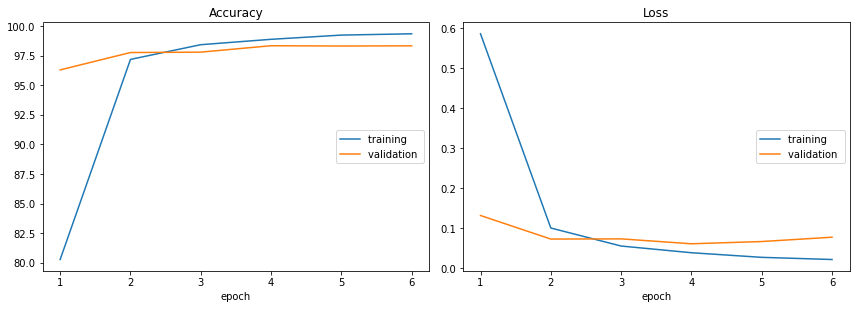

Accuracy
	training         	 (min:   80.277, max:   99.342, cur:   99.342)
	validation       	 (min:   96.292, max:   98.333, cur:   98.325)
Loss
	training         	 (min:    0.021, max:    0.586, cur:    0.021)
	validation       	 (min:    0.060, max:    0.131, cur:    0.077)
Epoch 00007: early stopping
Test:
	Loss:  0.075
	Accuracy:  98.100


In [0]:
# Artık alımlı, şekilli bir eğitim döngüsü başlatabiliriz. Her epochda kaydolan güncel durumu grafiklerde izleyin
# GPU yu kullandığınıza emin olun
fancy_poutyne_train(model_name='mnist3', pytorch_model=mnist3)

LiveLossPlot sayesinde artık tüm süslü grafikleri görebiliyoruz!

_**Şimdi küçük bir deney yapabilir ve kendiniz için modelin nasıl uydurmaya başladığını görebilirsiniz. Erken Durdurma callbackini eitim döngüsünden kaldırmanız yeterli olacaktır.**_

Bu kadar basit bir veri setinde bile modelin overfit olabildiğini gözlemleyebilirsiniz!


###9. SONUÇ

Elimizde eğitimli bir model var. Şimdi, PyTorch Modelimizin tahminlerinin tadını çıkarabileceğimiz basit bir çıkarım rutini yazmak isteyebiliriz, di mi? (:

In [0]:
# A rather straightforward inference routine 

def inference():
    PATH = 'mnist3_last_epoch.ckpt' # Path to the saved model checkpoint

    # Load the model 
    model = MNISTModel1().to('cpu') # Instantiate our PyTorch model 
    model.load_state_dict(torch.load(PATH)) # Load the saved model 
    # summary(model, (1, 28, 28), device='cpu') # Check if everything is correct 

    # Time to get some 'test_loader' data for our model 
    dataiter = iter(train_loader) # Get the whole batch 
    images, labels = dataiter.next() # Extract the images and their labels 
    label = labels[0] # The ground truth

    # Images need a little bit of processing! 
    image = images[0] # Take the first image from the batch = 1 x 28 x 28
    # Remember that our Model expects the first dimension as a 'batch size' 
    # Therefore, we add one extra dimension in the 'start.  
    image = torch.unsqueeze(image, dim=0) # 1 x 1 x 28 x 28 (batch_size = 1)
    print('\nimage.shape =>', image.shape)

    # Disable the autograd module 
    with torch.no_grad(): # no need to calculate the gradients as we are not training
        # Make a forward-pass 
        output = model.forward(image)
    
    # Our model outputs 'logits', we need to transform it into class probabilities. 
    # https://discuss.pytorch.org/t/how-to-extract-probabilities/2720/12
    # To transform logits, we need to use the 'Softmax' function
    # https://medium.com/data-science-bootcamp/understand-the-softmax-function-in-minutes-f3a59641e86d
    # Therefore,  
    class_probabilities = F.softmax(output, dim=1).numpy().squeeze()
    print('\nClass Probabilities ==>', class_probabilities)
    for i, proba in enumerate(class_probabilities):
        print(f'Class \t{i}\t Probability \t{100*proba:.2f}%')

    # A very Fancy way to showcase the results 
    # Create a figure with two axes, ax1 and ax2
    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2) # Subplot with 2 columns
    # ax1 holds the image from the test dataset
    ax1.imshow(image.resize_(1, 28, 28).numpy().squeeze())
    ax1.set_title('Ground Truth ' + str(label.numpy()))
    # ax2 holds a horizontal bar chart containing class_probabilities 
    ax2.barh(np.arange(10), class_probabilities)
    ax2.set_aspect(0.1) # aspect ratio of ax2, else it will get too big
    ax2.set_yticks(np.arange(10)) # 10 ticks on the y-axis for 10 classes
    ax2.set_yticklabels(np.arange(10)) # set the ticklabels from 0 to 9
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1) # probability can't be over 1, hence set limit to 1.1

    return None


image.shape => torch.Size([1, 1, 28, 28])

Class Probabilities ==> [1.00e+00 1.89e-13 1.45e-08 1.89e-13 1.89e-13 3.16e-13 6.20e-12 1.89e-13 5.37e-13 2.05e-10]
Class 	0	 Probability 	100.00%
Class 	1	 Probability 	0.00%
Class 	2	 Probability 	0.00%
Class 	3	 Probability 	0.00%
Class 	4	 Probability 	0.00%
Class 	5	 Probability 	0.00%
Class 	6	 Probability 	0.00%
Class 	7	 Probability 	0.00%
Class 	8	 Probability 	0.00%
Class 	9	 Probability 	0.00%


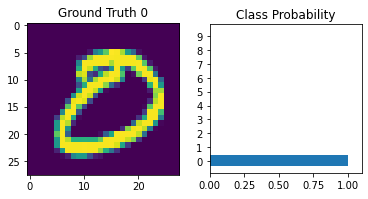

In [0]:
inference() 

_**TEBRİKLER!!!**_

Derin Öğrenme Modeliniz için tam bir çıkarım döngüsü yazmış oldunuz!

![Congratulations](https://media.giphy.com/media/l4HodBpDmoMA5p9bG/giphy.gif)

###10. Teşekkürler!

Geçtiğimiz hafta içinde [People In Data](https://www.facebook.com/peopleindata/) ve [Facebook DevC Stockholm](https://www.facebook.com/groups/devCstockholm/) ortaklığıyla düzenlenen etkinlikte **Udacity AI** mentorlerinden Pranjal ile tanışmış oldum ve harika bir webinar gerçekleştirdi. Tabi hem Pytorch'a ısınmam için hem de bu sırada meraklılarına faydalı olması adına bu notebook'u hazırlamaya karar verdim. Destek veren [Pranjal](https://www.linkedin.com/in/pranjall/?originalSubdomain=in)'a ve bu etkinlik hakkında beni haberdar ettiği için [Zümrüt](https://www.linkedin.com/in/zumrut-muftuoglu-98704537/)e teşekkürler.

---
**Daha fazla içerik için: _[Yapay Zekâ Araştırma İnisiyatifi](https://yz-ai.github.io/)_'ni de takip edebilirsiniz.**

_**PyTorch ile Derin Öğrenme yolculuğunuzda korkusuz olun ve sağlıkla kalın!**_ 

![](https://media.giphy.com/media/YUTlb7DyygFMs/giphy.gif)